## Фильтры границ

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import cv2
import random

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torchvision.datasets import FashionMNIST

# __________end of block__________

Продолжим работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

__Ваша задача: реализовать механизм выделения границ (Sobel filter) и упрощенный вариант построения гистограммы ориентированных градиентов.__

Точность классификации оцениваться не будет, вам лишь необходимо реализовать функции и сдать их в контест.

В ноутбуке присутствует несколько тестов, которые помогут вам отладить свое решение.

Text(0.5, 1.0, 'Image label: 6')

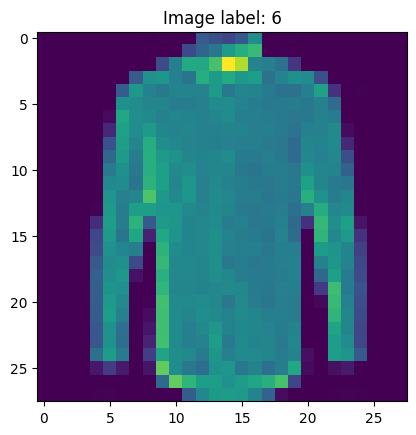

In [3]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)

train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

#### Шаг 1. Sobel filtering
Реализуйте функцию `compute_sobel_gradients_two_loops`. Часть функции уже написана, пожалуйста, не меняйте написанный код.

In [86]:
# do not change the code in the block below
# __________start of block__________
import numpy as np
def compute_sobel_gradients_two_loops(image):
    # Get image dimensions
    height, width = image.shape # длина, ширина

    # Initialize output gradients
    # Создаем массив размера image для дальнейшей записи градиентов
    gradient_x = np.zeros_like(image, dtype=np.float64)
    gradient_y = np.zeros_like(image, dtype=np.float64)

    # Pad the image with zeros to handle borders
    # Добавляем padding
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
# __________end of block__________

    # Define the Sobel kernels for X and Y gradients
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float64)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float64)

    # Apply Sobel filter for X and Y gradients using convolution
    for i in range(1, height + 1):
        for j in range(1, width + 1):
            gradient_x[i - 1, j - 1] = (
            padded_image[i-1][j-1]*(-1) + padded_image[i-1][j]*0 + padded_image[i-1][j+1]*1 +
            padded_image[i][j-1]*(-2) + padded_image[i][j]*0 + padded_image[i][j+1]*2 +
            padded_image[i+1][j-1]*(-1) + padded_image[i+1][j]*0 + padded_image[i+1][j+1]*1)
            gradient_y[i - 1, j - 1] =(
            padded_image[i-1][j-1]*(-1) + padded_image[i-1][j]*(-2) + padded_image[i-1][j+1]*(-1) +
            padded_image[i][j-1]*0 + padded_image[i][j]*0 + padded_image[i][j+1]*0 +
            padded_image[i+1][j-1]*1 + padded_image[i+1][j]*2 + padded_image[i+1][j+1]*1)
    return gradient_x, gradient_y

Для проверки написанного кода мы обратимся к уже реализованной версии в из opencv. Ввиду того, что операция padding'а может произвоиться иначе, будем игнорировать расхождения на краях изображения.

In [5]:
# do not change the code in the block below
# __________start of block__________
def compute_sobel_gradients_opencv(image):
    # Apply Sobel filter for horizontal and vertical gradients
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Return gradients in both directions
    return sobel_x, sobel_y
# __________end of block__________


In [6]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)
gradients_opencv = compute_sobel_gradients_opencv(image)

assert np.allclose(gradients_two_loops[0][1:-1, 1:-1], gradients_opencv[0][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[0] and gradients_opencv[0] are not close"
assert np.allclose(gradients_two_loops[1][1:-1, 1:-1], gradients_opencv[1][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[1] and gradients_opencv[1] are not close"
print("Everything seems fine!")
# __________end of block__________


Everything seems fine!


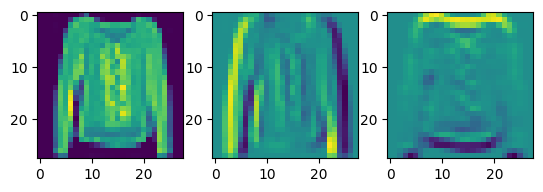

In [7]:
image = random.choice(train_fmnist_data)[0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(gradients_two_loops[0])
plt.subplot(1, 3, 3)
plt.imshow(gradients_two_loops[1])

#### Шаг 2. Подсчет градиентов в полярных координатах.
Реализуйте две функции:
 * `compute_gradient_magnitude`, котрая считает евклидову норму градиента
 * `compute_gradient_direction`, которая счиает его направление в виде угла относительно оси $x$. Возвращаемый угол должен быть в диапазоне $(-180; 180]$.

In [87]:
import numpy as np # for your convenience when you copy the code to the contest
def compute_gradient_magnitude(sobel_x, sobel_y):
    '''
    Compute the magnitude of the gradient given the x and y gradients.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        magnitude: numpy array of the same shape as the input [0] with the magnitude of the gradient.
    '''
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    return magnitude


def compute_gradient_direction(sobel_x, sobel_y):
    '''
    Compute the direction of the gradient given the x and y gradients. Angle must be in degrees in the range (-180; 180].
    Use arctan2 function to compute the angle.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        gradient_direction: numpy array of the same shape as the input [0] with the direction of the gradient.
    '''
    gradient_direction = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    return gradient_direction


Небольшие тесты для функции `compute_gradient_direction`

In [18]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

magnitudes = compute_gradient_magnitude(gradients_two_loops[0], gradients_two_loops[1])
angles = compute_gradient_direction(gradients_two_loops[0], gradients_two_loops[1])
assert np.all(magnitudes >= 0), "Magnitudes should be non-negative"
assert np.all(angles > -180) and np.all(angles <= 180), "Angles should be in the range (-180, 180]"
print("Everything seems fine!")
# __________end of block__________


Everything seems fine!


Пример визуализации итоговых границ, полученных с помощью фильтра Собеля:

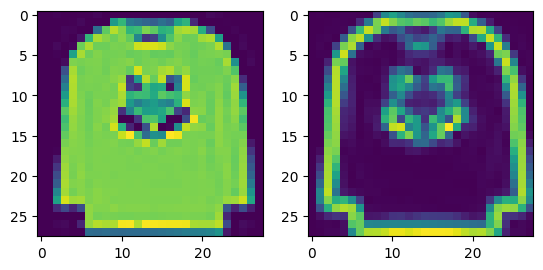

In [19]:
image = random.choice(train_fmnist_data)[0][0].numpy()
magnitudes = compute_gradient_magnitude(*compute_sobel_gradients_two_loops(image))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(magnitudes)

#### Шаг 3. Упрощённый вариант HoG.
Вам предстоит реализовать гистограмму ориентированных градиентов (HoG). В общем виде это происходит следующим образом:
1. Перевод изображения в одноканальное. Если изображение цветное, то оно долнжо быть преобразовано в оттенки серого. Можно воспользоваться формулой из [Wiki](https://en.wikipedia.org/wiki/Grayscale):
$$
\text{brightness}_{i, j} = \text{Red}_{i, j} * 0.2126 + \text{Green}_{i, j} * 0.7152 + \text{Blue}_{i, j} * 0.0722,
$$
но для простоты просто будем усреднять все каналы.

*Примечание: это далеко не единственный способ преобразования, и он может быть нелинейным. Подробности доступны по ссылке выше*.

2. Вычисление градиентов изображения с помощью фитра Собеля.

3. Определение направления и нормы градиента для каждого пикселя.

4. Построение гистограмм направлений градиентов. Для этого изображение разбивается на непересекающиеся квадратные ячейки. Размер каждой ячейки задается параметром `pixels_per_cell`, который по умолчанию равен равным (8, 8). Для каждой ячейки изображения строится гистограмму направлений градиентов. Для этого:
    * Каждое направление градиента будет отнесено к определенному бину (всего 9 бинов от -180 до 180).
    * Для каждого бина все попавшие в нее нормы суммируются.
    * Построенная гистограмма нормируется (чтобы сумма всех бинов была равна 1).
5. Групповая нормализация гистограмм. Для большей адаптивности метода к изменениям освещенности производится нормировка. Подробнее о ней можно почитать [здесь](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). В данном задании она производиться **не будет**.

На этом этапе вам нужно выполнить только шаги 1-4. Обратите внимание, что **групповая нормализация** гистограмм не выполняется (этот шаг пропущен).

In [95]:
cell_size = 7
def compute_hog(image, pixels_per_cell=(cell_size, cell_size), bins=9):
    # 1. Convert the image to grayscale if it's not already (assuming the image is in RGB or BGR)
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  # Simple averaging to convert to grayscale

    # 2. Compute gradients with Sobel filter
    gradient_x, gradient_y = compute_sobel_gradients_two_loops(image)

    # 3. Compute gradient magnitude and direction
    magnitude = compute_gradient_magnitude(gradient_x, gradient_y)
    direction = compute_gradient_direction(gradient_x, gradient_y)

    # 4. Create histograms of gradient directions for each cell
    cell_height, cell_width = pixels_per_cell
    n_cells_x = image.shape[1] // cell_width
    n_cells_y = image.shape[0] // cell_height

    histograms = np.zeros((n_cells_y, n_cells_x, bins))
    bin_interval = 360 / bins

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            bins_mas =np.zeros(bins)
            # Вырежем кусочки, с которыми будем работать
            magnitude_cell = magnitude[i*cell_height:(i+1)*cell_height, j*cell_width: (j+1)*cell_width]
            direction_cell = direction[i*cell_height:(i+1)*cell_height, j*cell_width: (j+1)*cell_width]

            for y in range(cell_height):
              for x in range(cell_width):
                dir_cell = direction_cell[y][x] #% 180
                bin_num = int( dir_cell // bin_interval) % bins
                bin_num_next = (bin_num+1) % bins
                # bin_num = int((direction_cell[y][x] + 180) // bin_interval) % bins
                # bin_num_next = (bin_num+1) % bins


                bin_center = (bin_num + 0.5) * bin_interval
                # part_for_bins = (dir_cell % bin_interval) / bin_interval
                part_for_bins = (direction_cell[y][x] - bin_center) / bin_interval

                # part_for_bins = ((direction_cell[y][x] + 180) % bin_interval) / bin_interval
                bins_mas[bin_num] += (1-part_for_bins) * magnitude_cell[y][x]
                bins_mas[bin_num_next] += part_for_bins * magnitude_cell[y][x]

            hist_sum = np.sum(bins_mas)
            if hist_sum > 0:
              bins_mas /= hist_sum
            histograms[i, j] = bins_mas
    return histograms

Для запуска тестов ниже файлы `hog_data.npy` и `image_data.npy` из репозитория должны быть доступны в той же директории, что и ноутбук. Вы можете скачать их в репозитории.

In [97]:
# do not change the code in the block below
# __________start of block__________
image = random.choice(train_fmnist_data)[0][0].numpy()

hog = compute_hog(image)
assert hog.shape == (4, 4, 9), "hog should have shape (4, 4, 9) for the FashionMNIST image with default parameters"
print("Everything seems fine!")

assert os.path.exists("/content/hog_data.npy") and os.path.exists("/content/image_data.npy"), "hog_data.npy and image_data.npy should be in the same directory as the notebook"
with open("/content/hog_data.npy", "rb") as f:
    hog_data = np.load(f, allow_pickle=True)
with open("/content/image_data.npy", "rb") as f:
    image_data = np.load(f, allow_pickle=True)
for test_image, test_hog in zip(image_data, hog_data):
    hog = compute_hog(test_image)
    print(hog)
    print("/////////////////")
    print(test_hog)
    assert np.allclose(hog, test_hog), "hog should be the same"

# __________end of block__________


Everything seems fine!
[[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
/////////////////
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.43804741e-02 3.89217686e-01 5.82091940e-01 4.30989965e-03
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.06459831e-03 2.46258710e-01 5.61750105e-01 1.90216854e-01
   7.09732234e-04]
  [0.00000000e+00 5.

AssertionError: hog should be the same

Визуализация полученных гистограмм. Сетка выглядит чуть сдвинутой из-за существенного размера пискеля, это нормально.

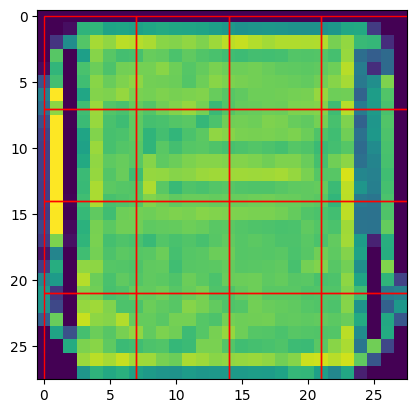

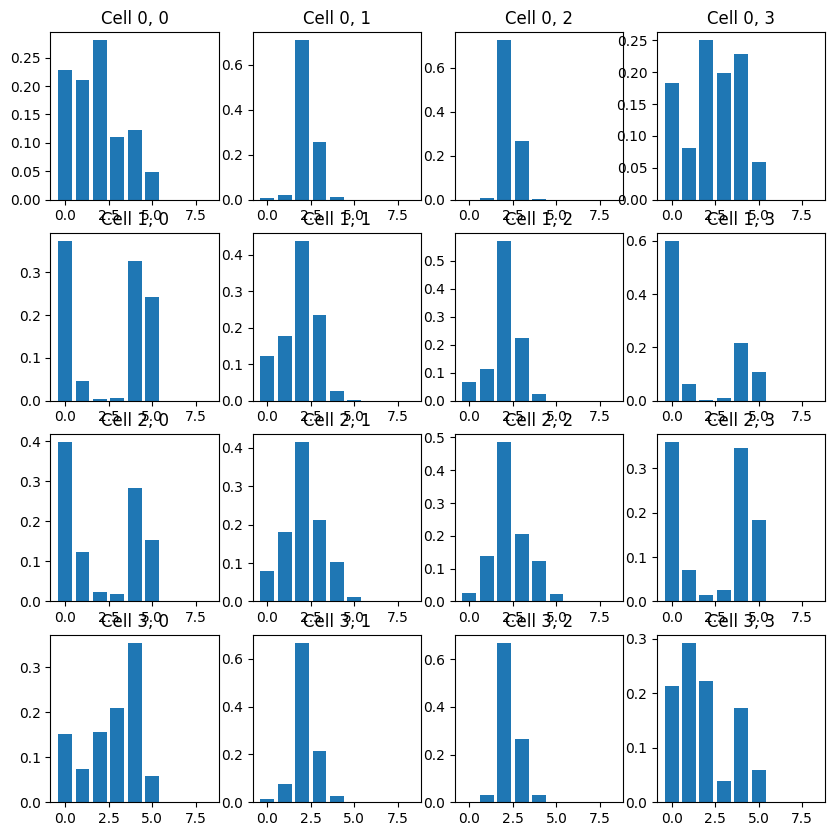

In [59]:
#plot all the histograms for (3, 3) cells:
image = random.choice(train_fmnist_data)[0][0].numpy()
hog = compute_hog(image)

# draw cells on the image
plt.imshow(image)
for i in range(4):
    for j in range(4):
        plt.gca().add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, fill=False, edgecolor='red', linewidth=1))
plt.show()


plt.figure(figsize=(10, 10))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.bar(range(len(hog[i, j])), hog[i, j])
        plt.title(f"Cell {i}, {j}")
plt.show()


### Сдача задания
Сдайте функции в задачу в соревновании. Не забудьте, что при вставке кода все импортируемые библиотеки также должны вставляться вместе с вашим кодом. Вы не должны использовать что-либо, кроме `numpy` при написании решения.

На этом задание завершено. Поздравляем!